In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [14]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [15]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour", "wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


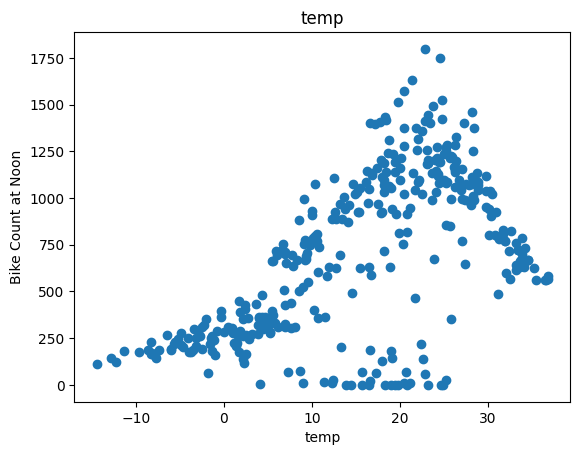

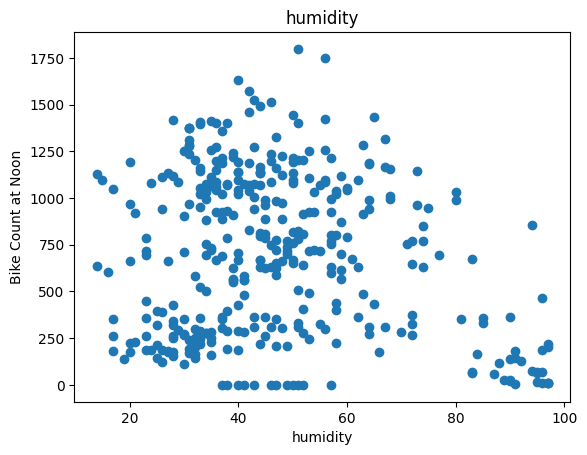

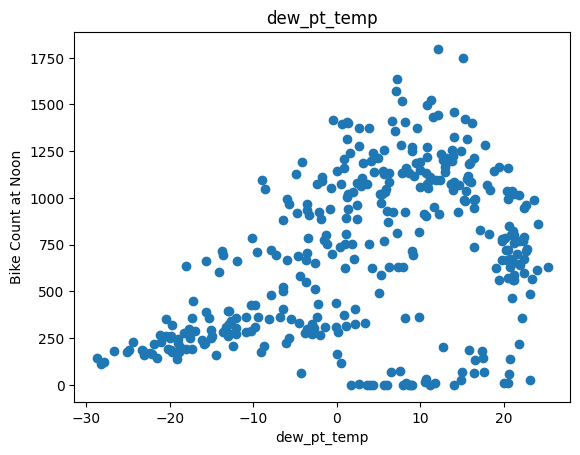

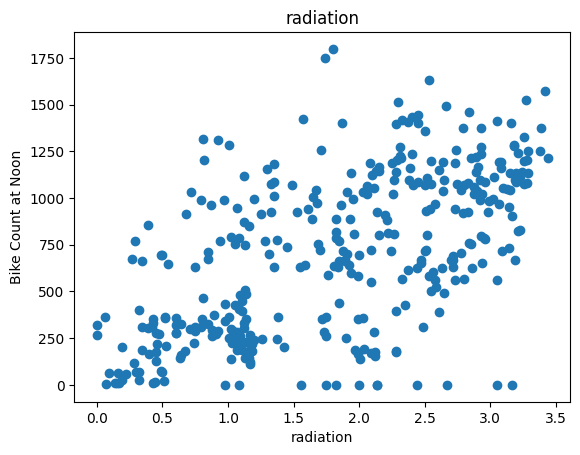

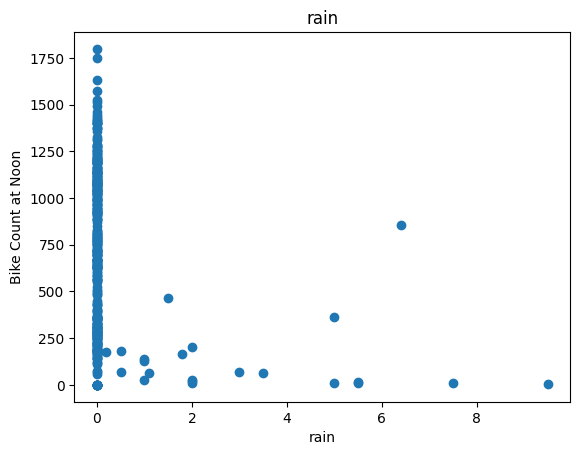

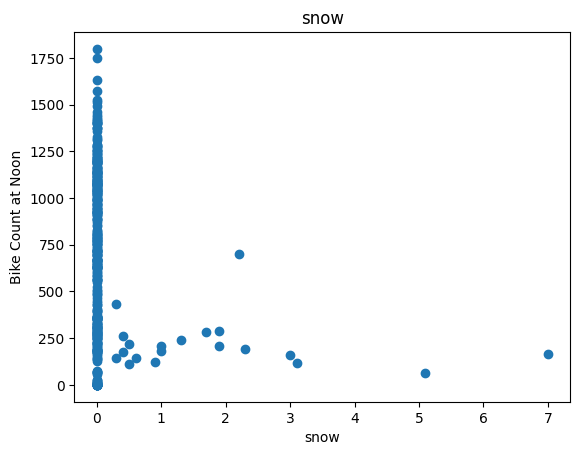

In [16]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

# Train/Validation/Test dataset split

In [17]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [30]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else :
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else :
      X = dataframe[x_labels].values
  
  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y

In [19]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [20]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [21]:
print(temp_reg.coef_, temp_reg.intercept_)

[[19.04876244]] [385.02895459]


In [22]:
temp_reg.score(x_test_temp, y_test_temp)

0.3665890621716251

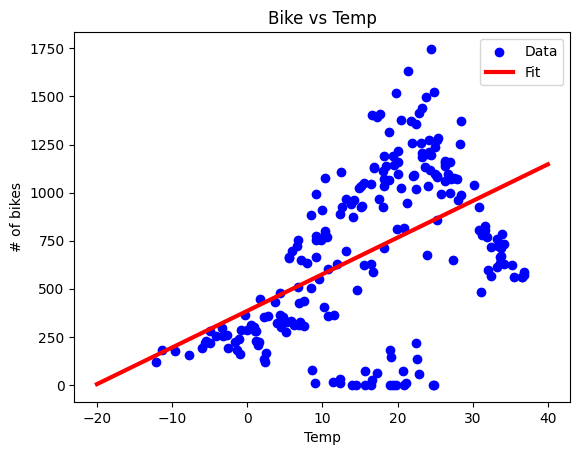

In [23]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("# of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Reg

In [25]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [31]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels = df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [32]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [33]:
all_reg.score(x_test_all, y_test_all)

0.5600313119780312

# Regression with Neural Network

In [34]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [35]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [36]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [38]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

In [39]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='lose')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)

  plt.show()

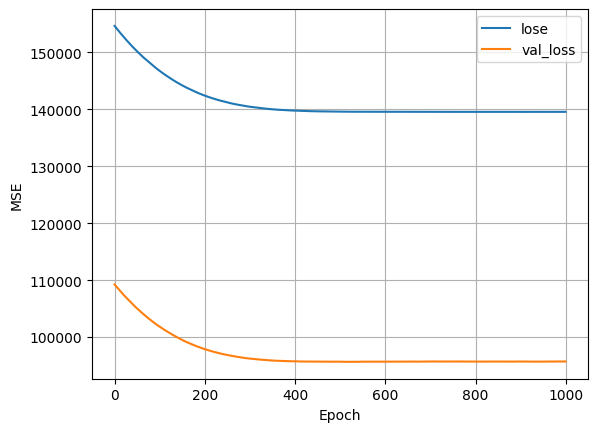

In [40]:
plot_loss(history)

4/4 [==============================] - 0s 726us/step


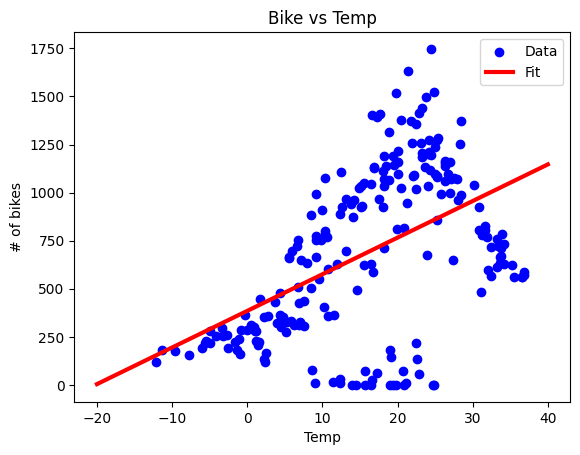

In [41]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("# of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Network

In [42]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [43]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_val_temp, y_val_temp),
    verbose=0, epochs=100
)

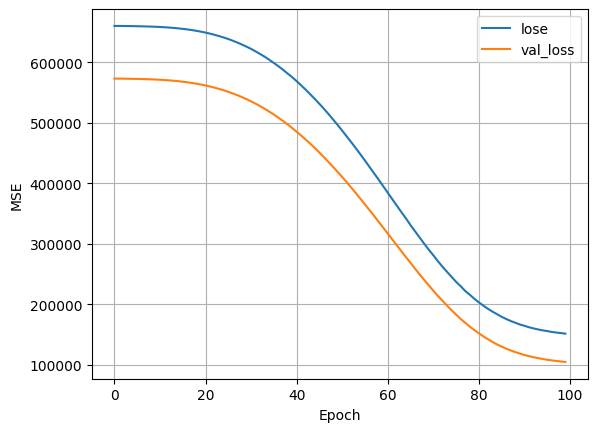

In [44]:
plot_loss(history)

4/4 [==============================] - 0s 762us/step


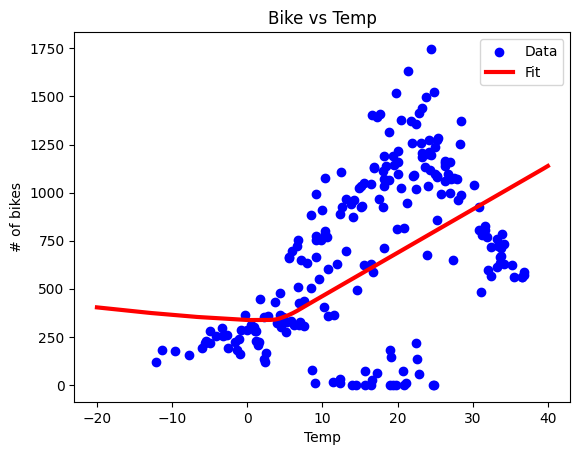

In [45]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("# of bikes")
plt.xlabel("Temp")
plt.show()

In [46]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(x_train_all)

In [47]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [48]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_val_all, y_val_all),
    verbose=0, epochs=100
)

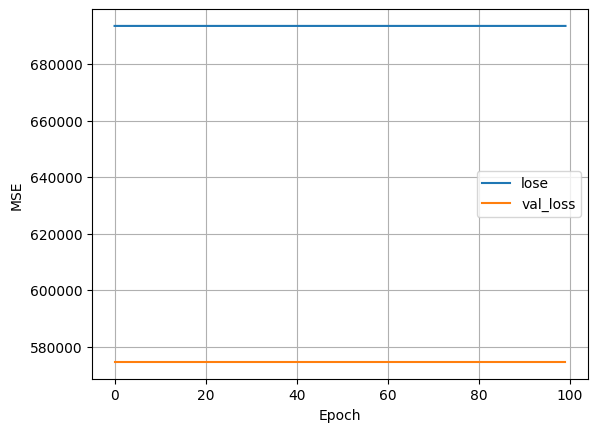

In [49]:
plot_loss(history)

In [50]:
# calculate the MSE for both linear reg and NN
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 999us/step


In [51]:
def MSE(y_pred, y_real):
  return(np.square(y_pred - y_real)).mean()

In [52]:
MSE(y_pred_lr, y_test_all)

74302.09300732237

In [53]:
MSE(y_pred_nn, y_test_all)

716237.1506849315

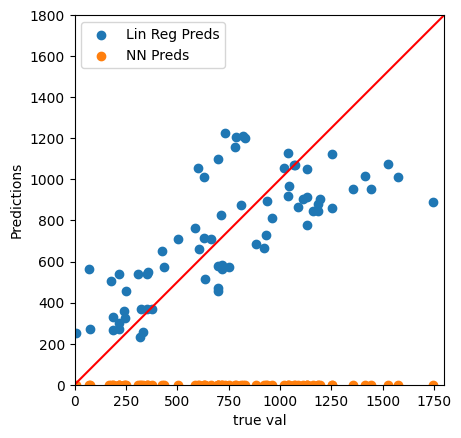

In [54]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("true val")
plt.ylabel("Predictions")
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')